# Breast cancer diagnostic

The aim is to find a good classifier capable of defining if a breast cancer is benign or malignant depending on some given parameters.

As a reference, the data set has been taken from https://www.kaggle.com/uciml/breast-cancer-wisconsin-data 

The data set is mainly explained in that site and the source of the data is provided.

## First look to the data set

We need to take a look to the csv columns delimiter and other issues that could be problematic at the time of the data import.

In [1]:
check_data = !head -n 2 'breast cancer wisconsin diagnostic data.csv'
check_data

['"id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst",',
 '842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189']

## Import libraries

All the necessary libraries are included herein. 
In case of any new library is needed, it is added here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold

# Data visualization

### Import data
The CSV file is imported taking the delimiter into consideration and then the first five rows are visualized in order to confirm the import process has been carried out as expected. 

In [3]:
# import csv file
breast_cancer = pd.read_csv('breast cancer wisconsin diagnostic data.csv', sep = ',')
breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Data overview

Count of values per row, mean, standard deviation, percentiles and max/min values are checked to understand the data distribution and try to capture any error in the data. There are some columns such as concavity_mean, concave points_mean, concavity_worst and concavity points_worst have a minimum value equal to zero, but it could be possible in this case. 
Columns, the count of non-null objects and the type of the values per column are displayed.

As well, the unique values at diagnosis column are checked to confirm there are only two types of diagnosis: benign or malignant.

Once all this data has been reviewed, it is concluded that there is not missing or mistaken data in the data set, so it can be used as is.

In [4]:
# data cleaning (last col missing values, the rest is clean)
breast_cancer = breast_cancer.loc[:, 'diagnosis':'fractal_dimension_worst']
print(breast_cancer.describe())
print(breast_cancer.info())
breast_cancer['diagnosis'].unique()

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

array(['M', 'B'], dtype=object)

### Labels distribution

There are enough labels for each diagnosis type to make good predictions, as can be seen in the histogram herein below.

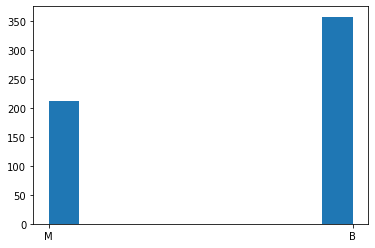

In [5]:
# plot a histogram to verify there is an enough number of each label 
plt.hist(breast_cancer['diagnosis'])
plt.show()

### Data preparation for visual comparison of mean values

In [6]:
# remap diagnosis labels
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'B':0, 'M':1})

# split df into benign and malignant to compare data distribution for both labels
breast_cancer_B = breast_cancer[breast_cancer['diagnosis'] == 0]
breast_cancer_M = breast_cancer[breast_cancer['diagnosis'] == 1]

# extract features
features = list(breast_cancer.columns[1:11])

### Create subplots to compare values distribution

In the figures below can be seen some important features when comparing their mean values distribution, for instance: radius_mean, perimeter_mean, area_mean, concavity_mean and concavity mean_points seem to be the most important features since the distributions of benign and malignant labels are not so coupled.
Nevertheless, let us confirm the suspect by mean of random forest features importances.

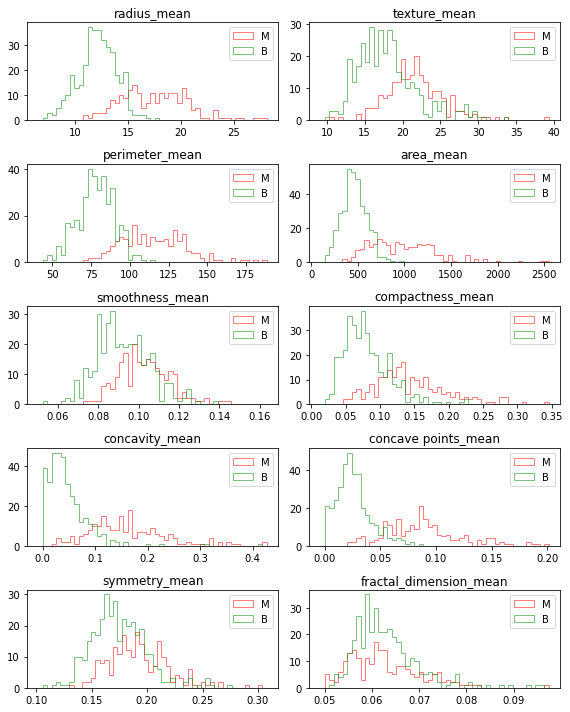

In [7]:
# create subplots for data mean values
fig, axes = plt.subplots(nrows=len(features)//2, ncols=2, figsize=(8, 10))
axes = axes.ravel()
num_bins = 50

# create each subplot
for idx, ax in enumerate(axes):
    ax.figure
    width_per_bin = (max(breast_cancer[features[idx]]) - min(breast_cancer[features[idx]])) / num_bins
    ax.hist([breast_cancer_B[features[idx]], breast_cancer_M[features[idx]]], 
            bins=np.arange(min(breast_cancer[features[idx]]) - width_per_bin, 
                           max(breast_cancer[features[idx]]) + width_per_bin, 
                           width_per_bin), 
            histtype='step', alpha = 0.5, color=['g', 'r'], label=['B', 'M'])
    ax.legend()
    ax.set_title(features[idx])
plt.tight_layout()
plt.show()

### Features importance

We are going to verify which are the most important features for the definition of benign and malignant labels and the weight of each one.
Anyway, all the features are going to be used in the models, which maybe can be finally improved by using these features.

In [8]:
# prepare data for train and test
X = breast_cancer.iloc[:, 1:11].values
y = breast_cancer['diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# run a quick random forest to see if features importances are in line with above distributions
rnd_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rnd_forest.fit(X, y)
features_imp = pd.Series(rnd_forest.feature_importances_, index=features).sort_values(ascending=False)
print(features_imp)

concave points_mean       0.322010
perimeter_mean            0.155791
area_mean                 0.133127
concavity_mean            0.121588
radius_mean               0.101471
texture_mean              0.071901
compactness_mean          0.034201
smoothness_mean           0.029496
fractal_dimension_mean    0.015447
symmetry_mean             0.014968
dtype: float64


# Machine learning models

For this type of problem, the following classifiers could be used:
- Random Forest
- SGD
- K-Neighbors
- Voting classifier including the previous classifiers.

They are analyzed, compared and the best one is going to be adapted into an Adaboost classifier.

A GridSearchCV has been run for all the models, except the Voting Classifier, to use the best parameters. This step has been removed from here for running speed purposes.

In [9]:
# random forest classifier model
model_forest = RandomForestClassifier(n_estimators=10,  criterion='entropy',
                                      max_depth=3, min_samples_leaf=2, 
                                      max_features='auto', random_state=21)
model_forest.fit(X_train, y_train)

# stochastic gradient descent classifier model
model_sgd = SGDClassifier(random_state=21, loss='log', penalty='l1', 
                          alpha=0.0001, max_iter=100, learning_rate='optimal', 
                          n_iter_no_change=15, eta0=0.1)
model_sgd.fit(X_train, y_train)

# KNeighbors classifier model
model_kneighbors = KNeighborsClassifier(n_neighbors=9, weights='distance', 
                                        algorithm='auto', leaf_size=2)
model_kneighbors.fit(X_train, y_train)

# VotingClassifier
model_voting = VotingClassifier(
    estimators=[('forest', model_forest), ('sgd', model_sgd), ('kneighbors', model_kneighbors)],
    voting='hard')
model_voting.fit(X_train, y_train)

models_list = [model_forest, model_sgd, model_kneighbors, model_voting]
models_name = ['Random Forest', 'SGD', 'K-Neighbors', 'Voting']

# print the scores of the four models
print('Random forest score: {:.2f}'.format(model_forest.score(X_test, y_test)))
print('SGD score: {:.2f}'.format(model_sgd.score(X_test, y_test)))
print('K-Neighbors score: {:.2f}'.format(model_kneighbors.score(X_test, y_test)))
print('Voting Classifier score: {:.2f}'.format(model_voting.score(X_test, y_test)))

Random forest score: 0.94
SGD score: 0.85
K-Neighbors score: 0.88
Voting Classifier score: 0.88


### Cross-validation scores

The previous scores show that Random Forest performs even better than the Voting Classifier. Nonetheless, a cross-validation score is calculated with 5 different splits. More or less splits do not change the result of this comparison.

The results confirm that Random Forest is the best one of these four models through all the splits.
A dataframe including all the croos-validation scores is returned as well as a plot to ease the visualization of the performance.

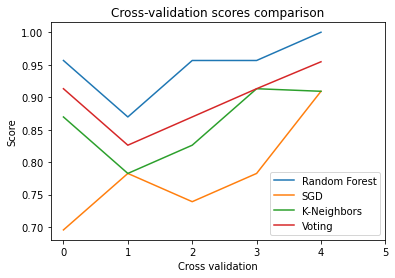

,Random Forest,SGD,K-Neighbors,Voting
0,0.96,0.70,0.87,0.91
1,0.87,0.78,0.78,0.83
2,0.96,0.74,0.83,0.87
3,0.96,0.78,0.91,0.91
4,1.00,0.91,0.91,0.95


In [10]:
# compare cross validated scores
cross_val_score_forest = cross_val_score(model_forest, X_test, y_test, cv=5)
cross_val_score_sgd = cross_val_score(model_sgd, X_test, y_test, cv=5)
cross_val_score_kneighbors = cross_val_score(model_kneighbors, X_test, y_test, cv=5)
cross_val_score_voting = cross_val_score(model_voting, X_test, y_test, cv=5)

cross_val_scores = [cross_val_score_forest, cross_val_score_sgd, 
                    cross_val_score_kneighbors, cross_val_score_voting]
cross_val_names = models_name.copy()

def print_scores(scores, c=0):
    
    """
    Create a list to link all the cross-validated scores
    to each model and create a dictionary for a pandas 
    dataframe generation.
    """
    
    scores_to_df = []
    for index, i in enumerate(scores[c]):
        scores_to_df.append(i)
    return scores_to_df

# create the pandas dataframe
dict_scores = {}
for i in range(len(cross_val_scores)):
    dict_scores[cross_val_names[i]] = print_scores(cross_val_scores, c=i)
df_scores = pd.DataFrame(dict_scores)

# plot the cross-validated scores stored in the pandas dataframe
plt.plot(df_scores)
plt.xlabel('Cross validation')
plt.xticks(np.arange(0, len(df_scores)+ 1, 1))
plt.ylabel('Score')
plt.legend(df_scores.columns)
plt.title('Cross-validation scores comparison')
plt.show()

pd.options.display.float_format = '{:.2f}'.format
df_scores

### ROC curves

Although Random Forest classifier seems to be the one performing best, we can compare the models by plotting the ROC curves and check their area ratio under the curve.

It is clear that Random Forest can be a good candidate.

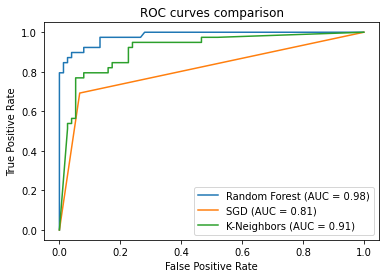

In [11]:
# Discard Voting Classifier due to no decision_function nor predict_proba
models_no_voting = models_list.copy()
del(models_no_voting[-1])
name_no_voting = models_name.copy()
del(name_no_voting[-1])

# plot roc curves
for m, n in zip(models_no_voting, name_no_voting):
    ax = plt.gca()
    plot_roc_curve(m, X_test, y_test, name=n, ax=ax)
ax.set_title('ROC curves comparison')
plt.show()

### Random Forest ROC curves cross-validation

It is important to ensure that Random Forest is consistent through different data splits and check how high is the standard deviation of all the splits. This way, it is possible to have a better idea of the performance variability of this model.

These ROC curves have been defined with 5 and 10 splits, but since no relevant changes have been detected between both numbers of splits, finally 5 splits are used. 

Conclusions:
- The standard deviation, represented by a light blue shaped area, is not high and almost all the splits are inside the standard deviation thresholds.
- The lowest AUC is 0.95 for fold 2.
- The mean AUC for all the splits is equal to 0.98 with a standard deviation of 0.02.
- Random Forest estimator could be good enough to pass to a Adaboost classifier as base estimator.

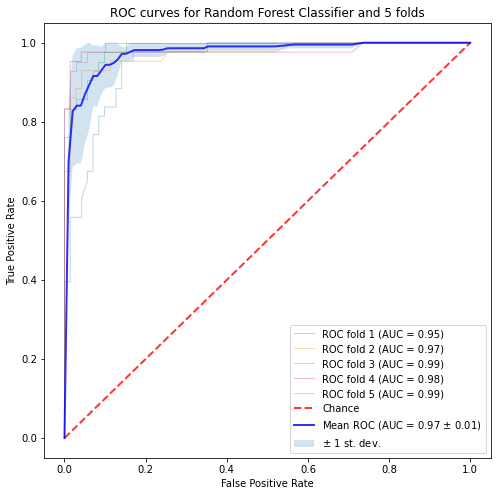

In [12]:
# Check AUC variation per rnd_forest classifier k-fold
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 8))
for i, (train, test) in enumerate(cv.split(X, y)):
    model_forest.fit(X[train], y[train])
    viz = plot_roc_curve(model_forest, X[test], y[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)
    aucs.append(auc(viz.fpr, viz.tpr))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0) 
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)

ax.plot(mean_fpr, mean_tpr, linestyle='-', lw=2, color='b', 
        label='Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc), alpha=0.8)
ax.fill_between(mean_fpr, tpr_lower, tpr_upper, label='$\pm$ 1 st. dev.', alpha=0.2)
ax.set_title('ROC curves for Random Forest Classifier and {} folds'.format(n_splits))

plt.legend()
plt.show()

### Adaboost model definition and comparison

An Adaboost is built using the previously defined Random Forest model as the base estimator. A GridSearchCV has been run to use the best parameters of the Adaboost model. This step has been removed from here for running speed purposes.

The adaboost model is then compared by means of the ROC curve to all the models, except the Voting Classifier. As can be seen, Random Forest is slightly improved with an AUC value very near to 1.

The score of Adaboost is higher than 0.97, even better than the score of 0.94 provided by the Random Forest model.

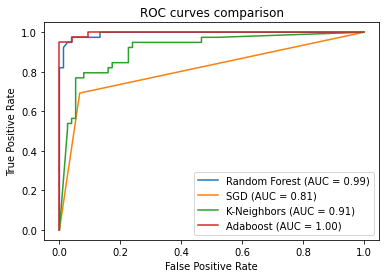

Adaboost score: 0.974


In [13]:
# adaboost classifier model
model_adaboost = AdaBoostClassifier(base_estimator=model_forest, learning_rate=0.1, 
                                   n_estimators=500, random_state=0)
model_adaboost.fit(X_train, y_train)

# Discard Voting Classifier due to no decision_function nor predict_proba
models_no_voting_adaboost = models_no_voting.copy()
models_no_voting_adaboost.append(model_adaboost)
name_no_voting_adaboost = name_no_voting.copy()
name_no_voting_adaboost.append('Adaboost')

# plot roc curves
for m, n in zip(models_no_voting_adaboost, name_no_voting_adaboost):
    ax = plt.gca()
    plot_roc_curve(m, X_test, y_test, name=n, ax=ax)
ax.set_title('ROC curves comparison')
plt.show()
print('Adaboost score: {:.3f}'.format(model_adaboost.score(X_test, y_test)))

### Adaboost ROC curves

As done previously for the Random Forest model, a k-fold verification is done for the Adaboost model with 5 and 10 different splits. Results are slightly worse with 10 folds, so this is the baseline to conclude the performance of the Adaboost. The following results are obtained:
- Worst AUC is equal to 0.96 for the fold 2.
- Mean AUC is equal to 0.99 with a standard deviation of 0.01.
- The standard deviation of the folds ROC curves is even smaller than for Random Forest.
- The performance is really good and it works better than the Random Forest alone.

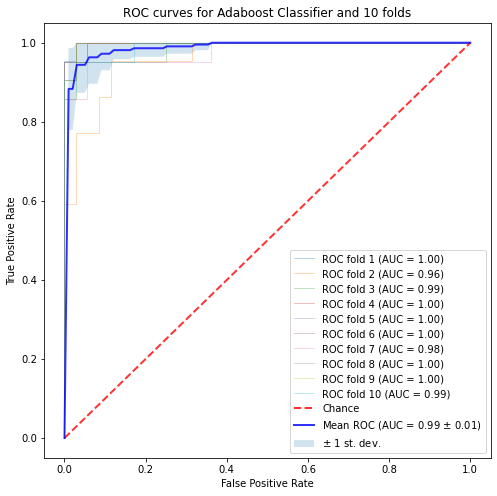

In [14]:
# Check AUC variation per Adaboost classifier k-fold
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=[8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    model_adaboost.fit(X[train], y[train])
    viz = plot_roc_curve(model_adaboost, X[test], y[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)
    aucs.append(auc(viz.fpr, viz.tpr))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0) 
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)

ax.plot(mean_fpr, mean_tpr, linestyle='-', lw=2, color='b', 
        label='Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc), alpha=0.8)
ax.fill_between(mean_fpr, tpr_lower, tpr_upper, label='$\pm$ 1 st. dev.', alpha=0.2)
ax.set_title('ROC curves for Adaboost Classifier and {} folds'.format(n_splits))

plt.legend()
plt.show()

# Conclusion

An Adaboost model using Random Forest as the base estimator performs benign/malignant classifications with high TP rates and low FP rates. 
There could be some cases where the classification performs worse, as happens in ROC fold 2 of the above ROC curves, but nevertheless, the AUC in this case is 0.96 even being the worst fold.
Besides of that, the score of this method is 0.974, so there is room for further improvements.


### Future Works

Future works shall be focused on trying other classifiers which could increase the current score of Adaboost model.
For instance, the following algorithms are serious candidates, apart from others not included in the list:

- Extra Trees
- Bagging
- Ridge
- Feel free to try others!


### Suggestions

Do not hesitate to suggest any correction, modification or enhancement of the analysis herein described!
Lots of thanks.
